In [1]:
# 忽略warnings
import warnings 
warnings.filterwarnings('ignore') 

# 导入Python通用库
import matplotlib.pyplot as plt
import numpy as np
import os

# 对于RNN类型的模型，用GPU没有太大优势，强制使用CPU
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   
# os.environ["CUDA_VISIBLE_DEVICES"] = ""

# 导入TF 2.0并设置GPU
import tensorflow as tf
# 导入Keras库
from tensorflow import keras
# 设置使用GPU显存的比例
# 对于RNN类型的模型，用GPU没有太大优势
from keras.backend.tensorflow_backend import set_session
config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.7
tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config)) 
# 导入模型、优化器、损失函数等等
# from tensorflow.keras import preprocessing
# from tensorflow.keras import regularizers
from tensorflow.keras import optimizers
# from tensorflow.keras import metrics
# from tensorflow.keras import models
# from tensorflow.keras import losses
# from tensorflow.keras import layers
# 导入Keras字符处理模块
from tensorflow.keras.layers import Flatten, Dense, Embedding, SimpleRNN, LSTM, GRU, Bidirectional
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
# 导入数据集
from keras.datasets import imdb

Using TensorFlow backend.


# 06. 深度学习用于文本和序列
本章将介绍使用深度学习模型处理文本、时间序列和一般的序列数据。用于处理序列的两种基本的深度学习算法分别是`循环神经网络`（recurrent neural network）和`一维卷积神经网络`（1D convnet），后者是上一章介绍的二维卷积神经网络的一维版本。本章将讨论这两种方法。

这些算法的应用包括：
+ 文档分类和时间序列分类，比如识别文章的主题或书的作者
+ 时间序列对比，比如估测两个文档或两支股票行情的相关程度
+ 序列到序列的学习，比如将英语翻译成法语
+ 情感分析，比如将推文或电影评论的情感划分为正面或负面
+ 时间序列预测，比如根据某地最近的天气数据来预测未来天气

## 6.3 循环神经网络的高级用法
本节将介绍提高循环神经网络的性能和泛化能力的三种高级技巧。我们将在温度预测问题中介绍这三个概念。在这个问题中，数据点时间序列来自建筑物屋顶安装的传感器，包括温度、气压、湿度等，你将要利用这些数据来预测最后一个数据点24小时之后的温度。这是一个相当有挑战性的问题，其中包含许多处理时间序列时经常遇到的困难。

我们将会介绍以下三种技巧：
+ **循环dropout**（recurrent dropout）：这是一种特殊的内置方法，在循环层中使用`dropout`来降低过拟合
+ **堆叠循环层**（stacking recurrent layers）：这会提高网络的表示能力（代价是更高的计算负荷）
+ **双向循环层**（bidirectional recurrent layer）：将相同的信息以不同的方式呈现给循环网络，可以提高精度并缓解遗忘问题

### 6.3.1 温度预测问题
除了语言处理，其他许多问题中也都用到了序列数据。本节我们将使用一个天气时间序列数据集，它由德国耶拿的`马克思 • 普朗克生物地球化学研究所`的气象站记录。

在这个数据集中，每10分钟记录14个不同的量（比如气温、气压、湿度、风向等），其中包含多年的记录。原始数据可追溯到2003年，但本例仅使用2009—2016年的数据。这个数据集非常适合用来学习处理数值型时间序列。我们将会用这个数据集来构建模型，输入最近的一些数据（几天的数据点），可以预测24小时之后的气温。

In [2]:
f = open("./data/jena_climate/jena_climate_2009_2016.csv")
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


从输出可以看出，共有420551行数据（每行是一个时间步，记录了一个日期和14个与天气有关的值）。

接下来，将420551行数据转换成一个`Numpy`数组。

In [3]:
float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

`图6-18`显示了温度（摄氏度）每年的周期性变化：

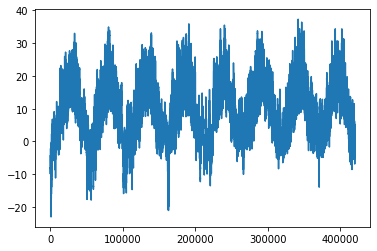

In [4]:
temp = float_data[:, 1] # 温度（单位：摄氏度）
plt.plot(range(len(temp)), temp)
plt.show()

`图6-19`显示了前10天温度数据的图像。因为每10分钟记录一个数据，所以每天有144个数据点。

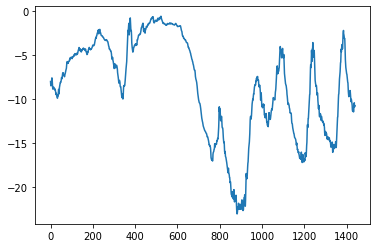

In [5]:
plt.plot(range(1440), temp[:1440])
plt.show()

在这张图中，你可以看到每天的周期性变化，尤其是最后4天特别明显。另外请注意，这10天一定是来自于很冷的冬季月份。

如果你想根据过去几个月的数据来预测下个月的平均温度，那么问题很简单，因为数据具有可靠的年度周期性。但从几天的数据来看，温度看起来更混乱一些。以天作为观察尺度，这个时间序列是可以预测的吗？我们来寻找这个问题的答案。

### 6.3.2 准备数据
这个问题的确切表述如下：一个时间步是10分钟，每`steps`个时间步采样一次数据，给定过去`lookback`个时间步之内的数据，能否预测`delay`个时间步之后的温度？用到的参数值如下：
+ `lookback = 720`：给定过去 5 天内的观测数据
+ `steps = 6`：观测数据的采样频率是每小时一个数据点
+ `delay = 144`：目标是未来 24 小时之后的数据

开始之前，你需要完成以下两件事。
+ 将数据预处理为神经网络可以处理的格式。数据已经是数值型的，所以不需要做向量化。但数据中的每个时间序列位于不同的范围（比如温度通道位于`-20`到`+30`之间，但气压大约在`1000`毫巴上下）。你需要对每个时间序列分别做标准化，让它们在相似的范围内都取较小的值
+ 编写一个`Python`生成器，以当前的浮点数数组作为输入，并从最近的数据中生成数据批量，同时生成未来的目标温度。因为数据集中的样本是高度冗余的（对于第`N`个样本和第`N+1`个样本，大部分时间步都是相同的），所以显式地保存每个样本是一种浪费。相反，我们将使用原始数据即时生成样本

预处理数据的方法是，将每个时间序列减去其平均值，然后除以其标准差。我们将使用前200000个时间步作为训练数据，所以只对这部分数据计算平均值和标准差。

In [6]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

下面的代码给出了将要用到的生成器。它生成了一个元组`(samples, targets)`，其中`samples`是输入数据的一个批量，`targets`是对应的目标温度数组。生成器的参数如下：
+ **data**：标准化后的浮点数数据组成的原始数组
+ **lookback**：输入数据应该包括过去多少个时间步
+ **delay**：目标应该在未来多少个时间步之后
+ **min_index**和**max_index**：data数组中的索引，用于界定需要抽取哪些时间步。这有助于保存一部分数据用于验证、另一部分用于测试
+ **shuffle**：是打乱样本，还是按顺序抽取样本
+ **batch_size**：每个批量的样本数
+ **step**：数据采样的周期（单位：时间步）。我们将其设为6，为的是每小时抽取一个数据点

In [7]:
def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

测试一下：
```python
data = np.arange(0, 1000).reshape(100, -1)
i = 0
for x,y in generator(data, lookback=5, delay=2, min_index=0, max_index=None, batch_size=1, step=1):
    print("samples: ", x)
    print("targets :", y)
    i+=1
    if i > 2:
        break
```

下面，我们使用这个抽象的`generator`函数来实例化三个生成器：一个用于训练，一个用于验证，还有一个用于测试。每个生成器分别读取原始数据的不同时间段：训练生成器读取前`200000`个时间步，验证生成器读取随后的`100000`个时间步，测试生成器读取剩下的时间步。

In [8]:
lookback = 1440
step = 6
delay = 144
batch_size = 256
# batch_size = 128

train_gen = generator(float_data, lookback=lookback, delay=delay, min_index=0, max_index=200000, 
                      shuffle=True, step=step, batch_size=batch_size)
val_gen = generator(float_data, lookback=lookback, delay=delay, min_index=200001, max_index=300000, 
                    step=step, batch_size=batch_size)
test_gen = generator(float_data, lookback=lookback, delay=delay, min_index=300001, max_index=None, 
                     step=step, batch_size=batch_size)

# 为了查看整个验证集，需要从val_gen中抽取多少次
val_steps = (300000 - 200001 - lookback)  //batch_size
# 为了查看整个测试集，需要从test_gen中抽取多少次
test_steps = (len(float_data) - 300001 - lookback)  //batch_size 

### 6.3.3 一种基于常识的、非机器学习的基准方法
开始使用黑盒深度学习模型解决温度预测问题之前，我们先尝试一种基于常识的简单方法。它可以作为合理性检查，还可以建立一个基准，更高级的机器学习模型需要打败这个基准才能表现出其有效性。面对一个尚没有已知解决方案的新问题时，这种基于常识的基准方法很有用。一个经典的例子就是不平衡的分类任务，其中某些类别比其他类别更常见。如果数据集中包含`90%`的类别`A`实例和`10%`的类别`B`实例，那么分类任务的一种基于常识的方法就是对新样本始终预测类别`A`。这种分类器的总体精度为`90%`，因此任何基于学习的方法在精度高于`90%`时才能证明其有效性。有时候，这样基本的基准方法可能很难打败。

本例中，我们可以放心地假设，温度时间序列是连续的（明天的温度很可能接近今天的温度），并且具有每天的周期性变化。因此，一种基于常识的方法就是始终预测24小时后的温度等于现在的温度。我们使用`平均绝对误差`（MAE）指标来评估这种方法。

In [9]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))

evaluate_naive_method()

0.2899222277291266


得到的`MAE`为`0.29`。因为温度数据被标准化成均值为0、标准差为1，所以无法直接对这个值进行解释。它转化成温度的平均绝对误差为`0.29×temperature_std`摄氏度，即`2.57 ℃`。

In [10]:
celsius_mae = 0.29 * std[1]
celsius_mae

2.5672247338393395

这个平均绝对误差还是相当大的。接下来的任务是利用深度学习知识来改进结果。

### 6.3.4 一种基本的机器学习方法
在尝试机器学习方法之前，建立一个基于常识的基准方法是很有用的；同样，在开始研究复杂且计算代价很高的模型（比如`RNN`）之前，尝试使用简单且计算代价低的机器学习模型也是很有用的，比如小型的密集连接网络。这可以保证进一步增加问题的复杂度是合理的，并且会带来真正的好处。

下面代码给出了一个密集连接模型，首先将数据展平，然后通过两个`Dense`层并运行。注意，最后一个`Dense`层没有使用激活函数，这对于回归问题是很常见的。我们使用`MAE`作为损失。评估数据和评估指标都与常识方法完全相同，所以可以直接比较两种方法的结果。

In [11]:
model = Sequential()
model.add(Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))
model.compile(optimizer=optimizers.RMSprop(), loss='mae')
history = model.fit(train_gen, steps_per_epoch=500, epochs=20, validation_data=val_gen, validation_steps=val_steps)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 500 steps, validate for 384 steps
Epoch 1/20
500/500 [==============================] - 12s 24ms/step - loss: 1.1339 - val_loss: 0.4868
Epoch 2/20
500/500 [==============================] - 12s 23ms/step - loss: 0.3496 - val_loss: 0.3027
Epoch 3/20
500/500 [==============================] - 11s 23ms/step - loss: 0.2729 - val_loss: 0.3191
Epoch 4/20
500/500 [==============================] - 11s 23ms/step - loss: 0.2542 - val_loss: 0.3431
Epoch 5/20
500/500 [==============================] - 11s 23ms/step - loss: 0.2416 - val_loss: 0.3202
Epoch 6/20
500/500 [==============================] - 11s 23ms/step - loss: 0.2324 - val_loss: 0.3103
Epoch 7/20
500/500 [==============================] - 11s 23ms/step - loss: 0.2261 - val_loss: 0.3271
Epoch 8/20
500/500 [==============================] - 12s 23ms/step - loss: 0.2216 - val_loss: 0.3310
Epoch 9/20
500/500 [==============================] - 11s 23ms/step - loss: 0.2175 - val_l

显示验证和训练的损失曲线：

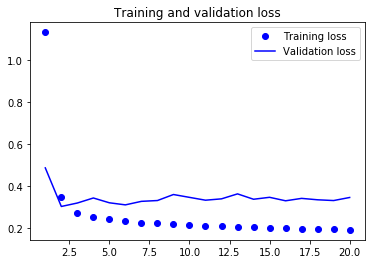

In [12]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

部分验证损失接近不包含学习的基准方法，但这个结果并不可靠。这也展示了首先建立这个基准方法的优点，事实证明，超越这个基准并不容易。我们的常识中包含了大量有价值的信息，而机器学习模型并不知道这些信息。

你可能会问，如果从数据到目标之间存在一个简单且表现良好的模型（即基于常识的基准方法），那为什么我们训练的模型没有找到这个模型并进一步改进呢？原因在于，这个简单的解决方案并不是训练过程所要寻找的目标。我们在模型空间（即假设空间）中搜索解决方案，这个模型空间是具有我们所定义的架构的所有两层网络组成的空间。这些网络已经相当复杂了。如果你在一个复杂模型的空间中寻找解决方案，那么可能无法学到简单且性能良好的基准方法，虽然技术上来说它属于假设空间的一部分。通常来说，这对机器学习是一个非常重要的限制：**如果学习算法没有被硬编码要求去寻找特定类型的简单模型，那么有时候参数学习是无法找到简单问题的简单解决方案的**。

### 6.3.5 第一个循环网络基准
第一个全连接方法的效果并不好，但这并不意味着机器学习不适用于这个问题。前一个方法首先将时间序列展平，这从输入数据中删除了时间的概念。我们来看一下数据本来的样子：它是一个序列，其中因果关系和顺序都很重要。我们将尝试一种循环序列处理模型，它应该特别适合这种序列数据，因为它利用了数据点的时间顺序，这与第一个方法不同。

我们将使用`Chung`等人在2014年开发的`GRU`层，而不是上一节介绍的`LSTM`层。`门控循环单元`（GRU，gated recurrent unit）层的工作原理与`LSTM`相同。但它做了一些简化，因此运行的计算代价更低（虽然表示能力可能不如`LSTM`）。机器学习中到处可以见到这种计算代价与表示能力之间的折中。

> CHUNG J, GULCEHRE C, CHO K, et al. Empirical evaluation of gated recurrent neural networks on sequence modeling. [C]//Conference on Neural Information Processing Systems, 2014

In [13]:
model = Sequential()
model.add(GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(Dense(1))

model.compile(optimizer=optimizers.RMSprop(), loss='mae')
history = model.fit(train_gen, steps_per_epoch=500, epochs=20, validation_data=val_gen, validation_steps=val_steps)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 500 steps, validate for 384 steps
Epoch 1/20
500/500 [==============================] - 19s 37ms/step - loss: 0.2991 - val_loss: 0.2739
Epoch 2/20
500/500 [==============================] - 17s 34ms/step - loss: 0.2803 - val_loss: 0.2643
Epoch 3/20
500/500 [==============================] - 17s 35ms/step - loss: 0.2740 - val_loss: 0.2655
Epoch 4/20
500/500 [==============================] - 17s 34ms/step - loss: 0.2683 - val_loss: 0.2632
Epoch 5/20
500/500 [==============================] - 17s 34ms/step - loss: 0.2627 - val_loss: 0.2657
Epoch 6/20
500/500 [==============================] - 17s 34ms/step - loss: 0.2564 - val_loss: 0.2701
Epoch 7/20
500/500 [==============================] - 17s 34ms/step - loss: 0.2505 - val_loss: 0.2729
Epoch 8/20
500/500 [==============================] - 17s 35ms/step - loss: 0.2435 - val_loss: 0.2766
Epoch 9/20
500/500 [==============================] - 17s 35ms/step - loss: 0.2372 - val_l

显示模型结果：

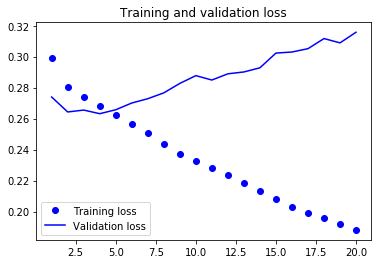

In [14]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

新的验证`MAE`约为0.265（在开始显著过拟合之前），反标准化转换成温度的平均绝对误差为`2.35℃`。与最初的误差`2.57℃`相比，这个结果确实有所提高，但可能仍有改进的空间。

### 6.3.6 使用循环dropout来降低过拟合
从训练和验证曲线中可以明显看出，模型出现过拟合：几轮过后，训练损失和验证损失就开始显著偏离。我们已经学过使用`dropout`降低过拟合，即将某一层的输入单元随机设为0，其目的是打破该层训练数据中的偶然相关性。但在循环网络中正确地使用`dropout`并不简单。人们早就知道，在循环层前面应用`dropout`会妨碍学习过程，而不是有所帮助。

2015 年，在关于贝叶斯深度学习的博士论文中，`Yarin Gal`确定了在循环网络中使用`dropout`的正确方法：对每个时间步应该使用相同的`dropout`掩码（dropout mask，相同模式的舍弃单元），而不是让`dropout`掩码随着时间步的增加而随机变化。此外，为了对`GRU`、`LSTM`等循环层得到的表示做正则化，应该将不随时间变化的`dropout`掩码应用于层的内部循环激活（叫作`循环dropout掩码`）。对每个时间步使用相同的`dropout`掩码，可以让网络沿着时间正确地传播其学习误差，而随时间随机变化的`dropout`掩码则会破坏这个误差信号，并且不利于学习过程。

> 参见`Yarin Gal`的博士论文“Uncertainty in deep learning”

`Yarin Gal`使用`Keras`开展这项研究，并帮助将这种机制直接内置到`Keras`循环层中。`Keras`的每个循环层都有两个与`dropout`相关的参数：一个是`dropout`，它是一个浮点数，指定该层输入单元的`dropout`比率；另一个是`recurrent_dropout`，指定循环单元的`dropout`比率。我们向`GRU`层中添加`dropout`和循环`dropout`，看一下这么做对过拟合的影响。因为使用`dropout`正则化的网络总是需要更长的时间才能完全收敛，所以网络训练轮次增加为原来的2倍。

> **Add by alex**
> 
> 原书代码运行结果loss为NAN，参考下面说明：
> Checked recurrent_dropout in details, it seems that the issue only occurs in implementation=2 which is the default in tf 2.0 (we changed from implementation 1 to 2 as default value). In short, the implementation 1 and 2 should be numerically same, but just be implemented differently. 1 uses more samll tensors and slide weights into individual gates, while 2 uses more bulk matmul.
> 
> The issue I believe is caused by an oversight when implementation 2 is introduce. When dropout is enabled, we applied the same dropout masks for all the gates, since it doesn't slide weights into individual gates. This might cause some numerical instability, eg if both candidate gate and forget gate gets the same masked state, they might be contradictory to each other (I don't have the detailed math proof here).
> 
> In short, for now you can build GRU with "implementation=1" in the init arg to walk around issue. I will send a fix very soon to force the implementation == 1 if the recurrent_dropout is specified.
> 
> [link](https://github.com/tensorflow/tensorflow/issues/32987)

In [15]:
model = Sequential()
model.add(GRU(32, dropout=0.2, recurrent_dropout=0.2, input_shape=(None, float_data.shape[-1]), implementation=1))
model.add(Dense(1))
model.compile(optimizer=optimizers.RMSprop(), loss='mae')
history = model.fit(train_gen, steps_per_epoch=500, epochs=40, validation_data=val_gen, validation_steps=val_steps)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 500 steps, validate for 384 steps
Epoch 1/40
500/500 [==============================] - 136s 272ms/step - loss: 0.3365 - val_loss: 0.2730
Epoch 2/40
500/500 [==============================] - 135s 269ms/step - loss: 0.3049 - val_loss: 0.2711
Epoch 3/40
500/500 [==============================] - 134s 269ms/step - loss: 0.3002 - val_loss: 0.2668
Epoch 4/40
500/500 [==============================] - 134s 269ms/step - loss: 0.2950 - val_loss: 0.2666
Epoch 5/40
500/500 [==============================] - 135s 269ms/step - loss: 0.2930 - val_loss: 0.2660
Epoch 6/40
500/500 [==============================] - 136s 271ms/step - loss: 0.2901 - val_loss: 0.2657
Epoch 7/40
500/500 [==============================] - 136s 271ms/step - loss: 0.2887 - val_loss: 0.2648
Epoch 8/40
500/500 [==============================] - 136s 272ms/step - loss: 0.2877 - val_loss: 0.2653
Epoch 9/40
500/500 [==============================] - 135s 271ms/step - lo

结果显示前30个轮次不再过拟合(*add by alex* 实测结果和原文不同！)。不过，虽然评估分数更加稳定，但最佳分数并没有比之前低很多。

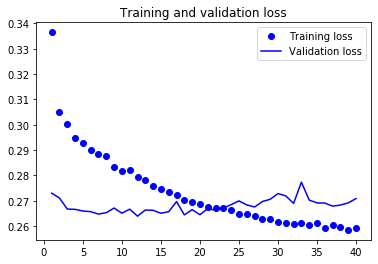

In [16]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### 6.3.7 循环层堆叠
模型不再过拟合，但似乎遇到了性能瓶颈，所以我们应该考虑增加网络容量。回想一下机器学习的通用工作流程：增加网络容量通常是一个好主意，直到过拟合变成主要的障碍（假设你已经采取基本步骤来降低过拟合，比如使用`dropout`）。只要过拟合不是太严重，那么很可能是容量不足的问题。

增加网络容量的通常做法是增加每层单元数或增加层数。`循环层堆叠`（recurrent layer stacking）是构建更加强大的循环网络的经典方法，例如，目前谷歌翻译算法就是7个大型`LSTM`层的堆叠——这个架构很大。

在`Keras`中逐个堆叠循环层，所有中间层都应该返回完整的输出序列（一个3D张量），而不是只返回最后一个时间步的输出。这可以通过指定`return_sequences=True`来实现。

In [17]:
model = Sequential()
model.add(GRU(32, dropout=0.1, recurrent_dropout=0.5, return_sequences=True, input_shape=(None, float_data.shape[-1]), implementation=1))
model.add(GRU(64, activation='relu', dropout=0.1, recurrent_dropout=0.5, implementation=1))
model.add(Dense(1))

model.compile(optimizer=optimizers.RMSprop(), loss='mae')
history = model.fit(train_gen, steps_per_epoch=400, epochs=40, validation_data=val_gen, validation_steps=val_steps)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 400 steps, validate for 384 steps
Epoch 1/40
400/400 [==============================] - 215s 537ms/step - loss: 0.3319 - val_loss: 0.2764
Epoch 2/40
400/400 [==============================] - 211s 527ms/step - loss: 0.3075 - val_loss: 0.2715
Epoch 3/40
400/400 [==============================] - 210s 526ms/step - loss: 0.3010 - val_loss: 0.2671
Epoch 4/40
400/400 [==============================] - 210s 525ms/step - loss: 0.2957 - val_loss: 0.2754
Epoch 5/40
400/400 [==============================] - 210s 525ms/step - loss: 0.2917 - val_loss: 0.2615
Epoch 6/40
400/400 [==============================] - 210s 525ms/step - loss: 0.2889 - val_loss: 0.2606
Epoch 7/40
400/400 [==============================] - 210s 525ms/step - loss: 0.2846 - val_loss: 0.2736
Epoch 8/40
400/400 [==============================] - 210s 525ms/step - loss: 0.2818 - val_loss: 0.2619
Epoch 9/40
400/400 [==============================] - 210s 525ms/step - lo

结果如下图所示。可以看到，添加一层的确对结果有所改进，但并不显著。我们可以得出两个结论：
+ 因为过拟合仍然不是很严重，所以可以放心地增大每层的大小，以进一步改进验证损失。但这么做的计算成本很高
+ 添加一层后模型并没有显著改进，所以你可能发现，提高网络能力的回报在逐渐减小

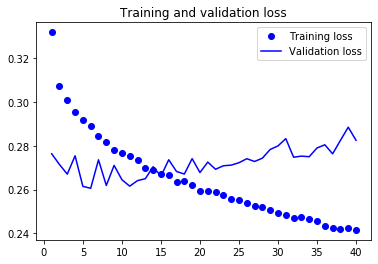

In [18]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### 6.3.8 使用双向 RNN
本节介绍的最后一种方法叫作`双向RNN`（bidirectional RNN）。`双向RNN`是一种常见的`RNN`变体，它在某些任务上的性能比普通`RNN`更好。它常用于自然语言处理，可谓深度学习对自然语言处理的瑞士军刀。

`RNN`特别依赖于顺序或时间，`RNN`按顺序处理输入序列的时间步，而打乱时间步或反转时间步会完全改变`RNN`从序列中提取的表示。正是由于这个原因，如果顺序对问题很重要（比如温度预测问题），`RNN`的表现会很好。`双向RNN`利用了`RNN`的顺序敏感性：它包含两个普通`RNN`，比如你已经学过的`GRU层`和`LSTM层`，每个`RNN`分别沿一个方向对输入序列进行处理（时间正序和时间逆序），然后将它们的表示合并在一起。通过沿这两个方向处理序列，`双向RNN`能够捕捉到可能被`单向RNN`忽略的模式。

值得注意的是，本节的`RNN`层都是按时间正序处理序列，这可能是一个随意的决定。至少，至今我们还没有尝试质疑这个决定。如果`RNN`按时间逆序处理输入序列，能否表现得足够好呢？我们在实践中尝试一下这种方法，看一下会发生什么。你只需要编写一个数据生成器的变体，将输入序列沿着时间维度反转（即将最后一行代码替换为`yield samples[:, ::-1, :], targets`）。本节第一个实验用到了一个`单GRU层`的网络，我们训练一个与之相同的网络，得到的结果如图所示。

In [19]:
def reverse_order_generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples[:, ::-1, :], targets
        
train_gen_reverse = reverse_order_generator(float_data, lookback=lookback, delay=delay, min_index=0, max_index=200000, 
                                            shuffle=True, step=step, batch_size=batch_size)
val_gen_reverse = reverse_order_generator(float_data, lookback=lookback, delay=delay, min_index=200001, max_index=300000, 
                                          step=step, batch_size=batch_size)

In [20]:
model = Sequential()
model.add(GRU(32, input_shape=(None, float_data.shape[-1]), implementation=1))
model.add(Dense(1))

model.compile(optimizer=optimizers.RMSprop(), loss='mae')
history = model.fit_generator(train_gen_reverse, steps_per_epoch=400, epochs=20, validation_data=val_gen_reverse, validation_steps=val_steps)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 400 steps, validate for 384 steps
Epoch 1/20
400/400 [==============================] - 16s 39ms/step - loss: 0.4817 - val_loss: 0.4873
Epoch 2/20
400/400 [==============================] - 15s 37ms/step - loss: 0.4507 - val_loss: 0.4653
Epoch 3/20
400/400 [==============================] - 15s 37ms/step - loss: 0.3952 - val_loss: 0.4591
Epoch 4/20
400/400 [==============================] - 15s 37ms/step - loss: 0.3558 - val_loss: 0.4087
Epoch 5/20
400/400 [==============================] - 15s 37ms/step - loss: 0.3272 - val_loss: 0.3955
Epoch 6/20
400/400 [==============================] - 15s 37ms/step - loss: 0.3057 - val_loss: 0.3776
Epoch 7/20
400/400 [==============================] - 15s 37ms/step - loss: 0.2928 - val_loss: 0.3793
Epoch 8/20
400/400 [==============================] - 15s 37ms/step - loss: 0.2798 - val_loss: 0.3791
Epoch 9/20
400

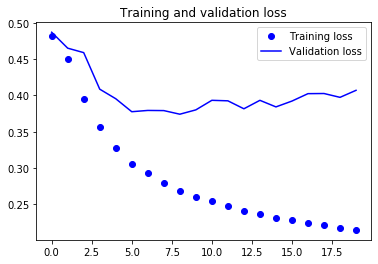

In [21]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

`逆序GRU`的效果甚至比基于常识的基准方法还要差很多，这说明在本例中，按时间正序处理对成功解决问题很重要。这非常合理：`GRU层`通常更善于记住最近的数据，而不是久远的数据，与更早的数据点相比，更靠后的天气数据点对问题自然具有更高的预测能力（这也是基于常识的基准方法非常强大的原因）。因此，按时间正序的模型必然会优于时间逆序的模型。

重要的是，对许多其他问题（包括自然语言）而言，情况并不是这样：直觉上来看，一个单词对理解句子的重要性通常并不取决于它在句子中的位置。我们尝试对6.2节`IMDB`示例中的`LSTM`应用相同的技巧。

In [22]:
# 作为特征的单词个数
max_features = 10000
# 在这么多单词之后截断文本（这些单词都属于前 max_features个最常见的单词）
maxlen = 500
# 加载数据
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
#（以下2行）将序列反转
x_train = [x[::-1] for x in x_train]  
x_test = [x[::-1] for x in x_test]    
# （以下2行）填充序列
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)  
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)    
# 定义模型
model = Sequential()
model.add(Embedding(max_features, 128))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))
# 训练模型
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 14s 718us/sample - loss: 0.4965 - acc: 0.7681 - val_loss: 0.3764 - val_acc: 0.8512
Epoch 2/10
20000/20000 [==============================] - 13s 654us/sample - loss: 0.3140 - acc: 0.8797 - val_loss: 0.3955 - val_acc: 0.8282
Epoch 3/10
20000/20000 [==============================] - 13s 655us/sample - loss: 0.2621 - acc: 0.9021 - val_loss: 0.3008 - val_acc: 0.8830
Epoch 4/10
20000/20000 [==============================] - 13s 653us/sample - loss: 0.2143 - acc: 0.9232 - val_loss: 0.3394 - val_acc: 0.8812
Epoch 5/10
20000/20000 [==============================] - 13s 656us/sample - loss: 0.1910 - acc: 0.9309 - val_loss: 0.3264 - val_acc: 0.8716
Epoch 6/10
20000/20000 [==============================] - 13s 657us/sample - loss: 0.1631 - acc: 0.9433 - val_loss: 0.3871 - val_acc: 0.8492
Epoch 7/10
20000/20000 [==============================] - 13s 651us/sample - loss: 0.1504 - acc: 0.9462 -

模型性能与正序`LSTM`几乎相同。值得注意的是，在这样一个文本数据集上，逆序处理的效果与正序处理一样好，这证实了一个假设：虽然单词顺序对理解语言很重要，但使用哪种顺序并不重要。重要的是，在逆序序列上训练的`RNN`学到的表示不同于在原始序列上学到的表示，正如在现实世界中，如果时间倒流，那么你的心智模型也会完全不同。在机器学习中，如果一种数据表示不同但有用，那么总是值得加以利用，这种表示与其他表示的差异越大越好，它们提供了查看数据的全新角度，抓住了数据中被其他方法忽略的内容，因此可以提高模型在某个任务上的性能。这是`集成`（ensembling）方法背后的直觉，我们将在第7章介绍集成的概念。

`双向RNN`正是利用这个想法来提高正序`RNN`的性能。它从两个方向查看数据（见`图6-25`），从而得到更加丰富的表示，并捕捉到仅使用正序`RNN`时可能忽略的一些模式。

<img src="images/06_25.png" style="width:300px;"/>

在`Keras`中将一个`双向RNN`实例化，我们需要使用`Bidirectional层`，它的第一个参数是一个循环层实例。`Bidirectional`对这个循环层创建了第二个单独实例，然后使用一个实例按正序处理输入序列，另一个实例按逆序处理输入序列。我们在`IMDB`情感分析任务上来试一下这种方法。

In [23]:
model = Sequential()
model.add(Embedding(max_features, 32))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 17s 832us/sample - loss: 0.5479 - acc: 0.7304 - val_loss: 0.3868 - val_acc: 0.8414
Epoch 2/10
20000/20000 [==============================] - 15s 744us/sample - loss: 0.3221 - acc: 0.8760 - val_loss: 0.3449 - val_acc: 0.8580
Epoch 3/10
20000/20000 [==============================] - 15s 743us/sample - loss: 0.2618 - acc: 0.9009 - val_loss: 0.3966 - val_acc: 0.8742
Epoch 4/10
20000/20000 [==============================] - 15s 740us/sample - loss: 0.2245 - acc: 0.9200 - val_loss: 0.3750 - val_acc: 0.8766
Epoch 5/10
20000/20000 [==============================] - 15s 750us/sample - loss: 0.1935 - acc: 0.9307 - val_loss: 0.4231 - val_acc: 0.8364
Epoch 6/10
20000/20000 [==============================] - 15s 734us/sample - loss: 0.1753 - acc: 0.9399 - val_loss: 0.3638 - val_acc: 0.8848
Epoch 7/10
20000/20000 [==============================] - 15s 738us/sample - loss: 0.1564 - acc: 0.9447 -

这个模型的表现比上一节的普通`LSTM`略好，验证精度超过`89%`。这个模型似乎也很快就开始过拟合，这并不令人惊讶，因为双向层的参数个数是正序`LSTM`的2倍。添加一些正则化，双向方法在这个任务上可能会有很好的表现。

接下来，我们尝试将相同的方法应用于温度预测任务。

In [24]:
model = Sequential()
model.add(Bidirectional(GRU(32), input_shape=(None, float_data.shape[-1])))
model.add(Dense(1))
model.compile(optimizer=optimizers.RMSprop(), loss='mae')
history = model.fit_generator(train_gen, steps_per_epoch=400, epochs=40, validation_data=val_gen, validation_steps=val_steps)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 400 steps, validate for 384 steps
Epoch 1/40
400/400 [==============================] - 32s 79ms/step - loss: 0.2988 - val_loss: 0.2735
Epoch 2/40
400/400 [==============================] - 30s 74ms/step - loss: 0.2747 - val_loss: 0.2673
Epoch 3/40
400/400 [==============================] - 30s 75ms/step - loss: 0.2695 - val_loss: 0.2721
Epoch 4/40
400/400 [==============================] - 30s 75ms/step - loss: 0.2623 - val_loss: 0.2675
Epoch 5/40
400/400 [==============================] - 30s 76ms/step - loss: 0.2548 - val_loss: 0.2769
Epoch 6/40
400/400 [==============================] - 30s 76ms/step - loss: 0.2486 - val_loss: 0.2687
Epoch 7/40
400/400 [==============================] - 30s 75ms/step - loss: 0.2425 - val_loss: 0.2752
Epoch 8/40
400/400 [==============================] - 30s 75ms/step - loss: 0.2365 - val_loss: 0.2815
Epoch 9/40
400/400 [==============================] - 30s 74ms/step - loss: 0.2296 - val_l

这个模型的表现与普通GRU层差不多一样好。其原因很容易理解：所有的预测能力肯定都来自于正序的那一半网络，因为我们已经知道，逆序的那一半在这个任务上的表现非常糟糕（本例同样是因为，最近的数据比久远的数据更加重要）。

### 6.3.9 更多尝试
为了提高温度预测问题的性能，你还可以尝试下面这些方法：
+ 在堆叠循环层中调节每层的单元个数。当前取值在很大程度上是任意选择的，因此可能不是最优的
+ 调节`RMSprop`优化器的学习率
+ 尝试使用`LSTM`层代替`GRU`层
+ 在循环层上面尝试使用更大的密集连接回归器，即更大的`Dense`层或`Dense`层的堆叠
+ 不要忘记最后在测试集上运行性能最佳的模型（即验证`MAE`最小的模型）。否则，你开发的网络架构将会对验证集过拟合

正如前面所说，深度学习是一门艺术而不是科学。我们可以提供指导，对于给定问题哪些方法可能有用、哪些方法可能没用，但归根结底，每个问题都是独一无二的，你必须根据经验对不同的策略进行评估。目前没有任何理论能够提前准确地告诉你，应该怎么做才能最优地解决问题。你必须不断迭代。

### 6.3.10 小结
下面是你应该从本节中学到的要点：
+ 我们在第4章学过，遇到新问题时，最好首先为你选择的指标建立一个基于常识的基准。如果没有需要打败的基准，那么就无法分辨是否取得了真正的进步
+ 在尝试计算代价较高的模型之前，先尝试一些简单的模型，以此证明增加计算代价是有意义的。有时简单模型就是你的最佳选择
+ 如果时间顺序对数据很重要，那么循环网络是一种很适合的方法，与那些先将时间数据展平的模型相比，其性能要更好
+ 想要在循环网络中使用`dropout`，你应该使用一个不随时间变化的`dropout掩码`与`循环dropout掩码`。这二者都内置于`Keras`的循环层中，所以你只需要使用循环层的`dropout`和`recurrent_dropout`参数即可
+ 与单个`RNN`层相比，`堆叠RNN`的表示能力更加强大。但它的计算代价也更高，因此不一定总是需要。虽然它在机器翻译等复杂问题上很有效，但在较小、较简单的问题上可能不一定有用
+ `双向RNN`从两个方向查看一个序列，它对自然语言处理问题非常有用。但如果在序列数据中最近的数据比序列开头包含更多的信息，那么这种方法的效果就不明显

> **注意**
> 
> 有两个重要的概念我们这里没有详细介绍：`循环注意`（recurrent attention）和`序列掩码`（sequence masking）。这两个概念通常对自然语言处理特别有用，但并不适用于温度预测问题。你可以在学完本书后对其做进一步研究。**


> **市场与机器学习**
> 
> 有些读者肯定想要采用我们这里介绍的方法，并尝试将其应用于预测股票市场上证券的未来价格（或货币汇率等）。市场的统计特征与天气模式等自然现象有很大差别。如果你只能访问公开可用的数据，那么想要用机器学习来打败市场是一项非常困难的任务，你很可能会白白浪费时间和资源，却什么也得不到。
> 
> 永远要记住，面对市场时，过去的表现并不能很好地预测未来的收益，正如靠观察后视镜是没办法开车的。与此相对的是，如果在数据集中过去能够很好地预测未来，那么机器学习非常适合用于这种数据集。